## PS1 Part 3: Bi-Linear Models and SGD

### Bilinear Models for Recommendation

For this problem, you will derive a very simple recommendation system that uses a combination of unsupervised and supervised approachs and demonstrates use of Stochastic Gradient Descent.

Specifically, in class we discussed recommender models of the form:
$$
f(user,movie) = \langle v_u,v_m \rangle + b_u + b_m + \mu
$$

where $v$ is a vector that represents a user's or movie's location in an N-Dimensional space, $b$ is a vector that represents a specific "bias" term for each movie and user, and $\mu$ is a scalar that represents a kind of global anchor or base score (i.e., a sort of average movie rating). This means that each user has two vectors (e.g., $v_{\mathrm{jack~smith}}$ and $b_{\mathrm{jack~smith}}$), and each movie has two vectors (e.g., $v_{\mathrm{Avengers}}$ and $b_{\mathrm{Avengers}}$), with each of those vectors being N-Dimensional (in class we used two dimensions). For this, we constructed a loss function as follows:
$$
Cost = Loss + Penalty
$$
where
$$
Loss = \Sigma_{(u,m)\in \mathrm{Ratings}} \frac{1}{2}\left( \langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)^2
$$
and
$$
Penalty = \frac{\lambda}{2}\left(\Sigma_u \left[\| v_u\|^2_2 + b_u^2\right] + \Sigma_m \left[\|v_m\|^2_2 + b_m^2\right]\right)
$$


### Task 1: Analytical Gradients
To use stochastic gradient descent, we first need to write down the gradients. Using the above cost function (including both the loss and penalty), compute the following partial derivatives:

$$
\frac{\partial \textrm{Cost}}{\partial v_u } = \frac{\partial \textrm{Loss}}{\partial v_u} + \frac{\partial \textrm{Penalty}}{\partial v_u}
= \Sigma_{(u,m)\in \mathrm{Ratings}} \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)\frac{\partial \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)}{\partial v_u} 
+ \frac{\lambda}{2} \frac{\partial \left(\Sigma_u \left[\| v_u\|^2_2 + b_u^2\right] + \Sigma_m \left[\|v_m\|^2_2 + b_m^2\right]\right)}{\partial v_u} 
$$
$$
=\Sigma_{(u,m)\in \mathrm{Ratings}} \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)\frac{\partial \langle v_u,v_m \rangle}{\partial v_u} + \frac{\lambda}{2}\Sigma_u \frac{\partial \| v_u\|^2_2}{\partial v_u} = \Sigma_{(u,m)\in \mathrm{Ratings}} \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)v_m + \lambda\Sigma_u v_u
$$


$$
\frac{\partial \textrm{Cost}}{\partial v_m } = \Sigma_{(u,m)\in \mathrm{Ratings}} \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)\frac{\partial \langle v_u,v_m \rangle}{\partial v_m} + \frac{\lambda}{2}\Sigma_m \frac{\partial \| v_m\|^2_2}{\partial v_m} = \Sigma_{(u,m)\in \mathrm{Ratings}}\left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)v_u + \lambda\Sigma_m v_m
$$


$$
\frac{\partial \textrm{Cost}}{\partial b_u} = \Sigma_{(u,m)\in \mathrm{Ratings}} \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)\frac{\partial \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)}{\partial b_u} 
+ \frac{\lambda}{2} \frac{\partial \left(\Sigma_u \left[\| v_u\|^2_2 + b_u^2\right] + \Sigma_m \left[\|v_m\|^2_2 + b_m^2\right]\right)}{\partial b_u}
$$
$$
= \Sigma_{(u,m)\in \mathrm{Ratings}} \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)\frac{\partial b_u}{\partial b_u} + \frac{\lambda}{2}\Sigma_u \frac{\partial b_u^2}{\partial b_u}
= \Sigma_{(u,m)\in \mathrm{Ratings}}\left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right) + \lambda\Sigma_u b_u
$$


$$
\frac{\partial \textrm{Cost}}{\partial b_m} = \Sigma_{(u,m)\in \mathrm{Ratings}} \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)\frac{\partial b_m}{\partial b_m} + \frac{\lambda}{2}\Sigma_m \frac{\partial b_m^2}{\partial b_m} = \Sigma_{(u,m)\in \mathrm{Ratings}} \left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)+ \lambda\Sigma_m b_m
$$


$$
\frac{\partial \textrm{Cost}}{\partial \mu} = \Sigma_{(u,m)\in \mathrm{Ratings}}\left(\langle v_u,v_m \rangle + b_u + b_m + \mu - y_{u,m}\right)
$$

You can either do this directly in the notebook using LaTeX notation, or via a scanned image. Please remember to show your work in how you computed the derivatives, not just the final result. Note: Recall that the partial derivative of e.g. Nicholas's rating on Titanic with respect to the user Mark would be zero. When computing your SGD updates, consider how this might impact individual terms for users and movies in the loss function.

### Task 2: Stochastic Gradient Descent
Now you are actually going to implement SGD on this type of model and optimize it until convergence on a toy dataset. To simplify the implementation, we'll actually make the model a little simpler than the one you derived updates for in task 1. Specifically, we'll just use:

$$
Cost = \Sigma_{(u,m)\in \mathrm{Ratings}} \frac{1}{2}\left( \langle v_u,v_m \rangle + \mu - y_{u,m}\right)^2 + \frac{\lambda}{2}\left(\| v_u\|^2_2 + \|v_m\|^2_2\right)
$$

This way all you have to estimate is two vectors — $v_u$ for each user and $v_m$ for each movie — and $\mu$ — a scalar value similar to an average rating. For simplicity, we'll assume here that the size of the latent space (K) is 2 (i.e., the length of each  $v_u$ & $v_m$).

Using your above gradients, write down the update equations for each vector using stochastic gradient descent. Once you have done this, implement those update equations in code like we did in the in-class notebook. For simplicity, you can just use a constant step size $\alpha$ if you wish, though you may change this if you want. Note: depending on exactly how you implement your model and what batch size you use, i.e., one point at a time, or some subset of data points, values of $\alpha$ anywhere between around 0.7 and 0.01 should be sufficient to converge the model in under 1000 epochs, i.e., passes through the dataset. If you implement more advanced tricks covered in some optional readings this can converge much faster, but that is not necessary for this assignment, and it does not matter to me how quickly your model coverges, so long as it does so.

Use the below small sample dataset of movie ratings for five users and six movies to perform stochastic gradient descent to update those vectors until your model converges. To initialize your SGD, you can use the initial weights/terms we provide below, or you can initialize the model any other way you wish -- the exact initialization should not make a big difference here.

In [1]:
# Your Code below!

In [2]:
import numpy as np
import pandas as pd
missing_ratings = pd.read_csv('missing.csv')
ratings = pd.read_csv('ratings.csv')
ratings

,movie,user,ratings
0,The Avengers,Alex,3.0
1,The Avengers,Priya,3.5
2,The Avengers,Yichen,3.5
3,When Harry Met Sally,Alex,3.0
4,When Harry Met Sally,Sally,4.5
5,When Harry Met Sally,Priya,3.0
6,When Harry Met Sally,Yichen,3.0
7,Silence of the Lambs,Alex,3.0
8,Silence of the Lambs,Sally,4.0
9,Silence of the Lambs,Juan,3.5


In [3]:
# Alternatively, if you prefer, you can convert it into numpy first:
ratings_numpy = ratings.to_numpy()
# ratings_numpy

Let's initialize the vectors to some random numbers, and $\mu$ to 2.5

In [4]:
K=2
user_names = ratings['user'].unique()
movie_names = ratings['movie'].unique()
mu= 2.5
# Setting the seed of the random generator to a value so that everyone sees the same initialization
# should should be able to comment out the below with no ill-effects on whatever model you implement
# this may just help us in office hours if folks have difficulty implementing things
np.random.seed(0)
V = pd.DataFrame(np.random.random((len(user_names)+len(movie_names),K)),index=np.hstack([user_names,movie_names]))
print(V)

                             0         1
Alex                  0.548814  0.715189
Priya                 0.602763  0.544883
Yichen                0.423655  0.645894
Sally                 0.437587  0.891773
Juan                  0.963663  0.383442
The Avengers          0.791725  0.528895
When Harry Met Sally  0.568045  0.925597
Silence of the Lambs  0.071036  0.087129
Shawshank Redemption  0.020218  0.832620
The Hangover          0.778157  0.870012
The Godfather         0.978618  0.799159


In [5]:
# Here is one example of how to go through rows of a ratings matrix
for index, rating in ratings.iterrows():
    user  = rating['user']
    movie = rating['movie']
    score = rating['ratings']
    # print(f"{user} gave {movie} a score of {score}")

In [6]:
# Here is an example of one way to access rows of V
for index, rating in ratings.iterrows():
    user  = rating['user']
    movie = rating['movie']
    # print(f"{user}'s location in V is {V.loc[user].to_numpy()}.")
    # print(f"{movie}'s location in V is {V.loc[movie].to_numpy()}.")

# You could also do it in Numpy directly, which will likely lead to much faster SGD updates,
# but that shouldn't be necessary for problems of this size. Up to you!

### Train your Bilinear Model using SGD

In [7]:
# Your Model building and training code here!
def cost(V,ratings,mu=2.5,lamb=0.1):
    cost=0
    for index, rating in ratings.iterrows():
        user  = rating['user']
        movie = rating['movie']
        score = rating['ratings']
        pred = V.loc[user].to_numpy().dot(V.loc[movie].to_numpy())
        cost += 0.5*(score + mu - pred)**2
    cost += lamb*0.5*(np.sum(V.loc[ratings['user'].unique()].to_numpy()**2) + np.sum(V.loc[ratings['movie'].unique()].to_numpy()**2))
    #sum or no?..........|^|
    return cost

$$
\Sigma_{(u,m)\in \mathrm{Ratings}} \left(\langle v_u,v_m \rangle + \mu - y_{u,m}\right)v_m + \lambda\Sigma_u v_u
$$

In [8]:
def movieSum(V,ratings):
    sum = 0
    for idx,rating in ratings.iterrows():
        user = rating['user']
        movie = rating['movie']
        score = rating['ratings']
        v_user = V.loc[user].to_numpy()
        v_movie = V.loc[movie].to_numpy()
        bracket = v_user.dot(v_movie)+mu-score
        sum += bracket * v_movie
    return sum

def userSum(V,ratings):
    sum = 0
    for idx,rating in ratings.iterrows():
        user = rating['user']
        movie = rating['movie']
        score = rating['ratings']
        v_user = V.loc[user].to_numpy()
        v_movie = V.loc[movie].to_numpy()
        bracket = v_user.dot(v_movie)+mu-score
        sum += bracket * v_user
    return sum

def grad_step_old(V,ratings,alpha,lamb):
    V -= alpha*np.array([movieSum(V,ratings) + lamb*v if int(i) < 5 else userSum(V,ratings)+lamb*v for i, (idx, v) in enumerate(V.iterrows())])

def grad_step(V,rating,alpha,lamb):
    global mu
    error = V.loc[rating['user']].to_numpy().dot(V.loc[rating['movie']].to_numpy()) + mu - rating['ratings']
    v_m = V.loc[rating['movie']].to_numpy()
    v_u = V.loc[rating['user']].to_numpy()
    V.loc[rating['user']] -= alpha * (error * v_m + lamb * v_u)
    V.loc[rating['movie']] -= alpha * (error * v_u + lamb * v_m)
    temp_mu = mu - alpha * error
    return temp_mu





In [9]:
#Visualise vectors with arrows
import matplotlib.pyplot as plt


def plot_vectors(V,ratings):

    plt.figure()
    for i,(idx,_)in enumerate(V.iterrows()):
        if i < 5:
            plt.arrow(0,0,V.iloc[i,0],V.iloc[i,1],color='blue',alpha=0.3)
        else:
            plt.arrow(0,0,V.iloc[i,0],V.iloc[i,1],color='red',alpha=0.3)

    plt.scatter(V.loc[ratings['user'].unique()][0],V.loc[ratings['user'].unique()][1],label='Users',color='blue')
    plt.scatter(V.loc[ratings['movie'].unique()][0],V.loc[ratings['movie'].unique()][1],label='Movies',color='red')

    for i,(idx,_)in enumerate(V.iterrows()):
        if i < 5:
            plt.text(V.iloc[i,0] +.02, V.iloc[i,1] + .01, idx, fontsize=8)
        else:
            plt.text(V.iloc[i,0] +.02, V.iloc[i,1] + .01, idx, fontsize=8)
    
    plt.legend()
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('User and Movie Vectors')
    plt.grid()
    plt.show()
    
# plot gradient
# this needs to be fixed, update for single gradient calculation
def plot_grad(V,ratings,alpha,lamb):
    grads = alpha*np.array([movieSum(V,ratings) + lamb*v if int(i) < 5 else userSum(V,ratings)+lamb*v for i, (idx, v) in enumerate(V.iterrows())])
    plt.figure()
    for i,p in enumerate(grads):
        if i < 5:
            plt.arrow(V.iloc[i,0],V.iloc[i,1],p[0],p[1],color='skyblue')
        else:
            plt.arrow(V.iloc[i,0],V.iloc[i,1],p[0],p[1],color='orange')
    plt.scatter(V.loc[ratings['user'].unique()][0],V.loc[ratings['user'].unique()][1],label='Users',color='blue',s=5)
    plt.scatter(V.loc[ratings['movie'].unique()][0],V.loc[ratings['movie'].unique()][1],label='Movies',color='red',s=5)
    plt.grid()
    plt.show()

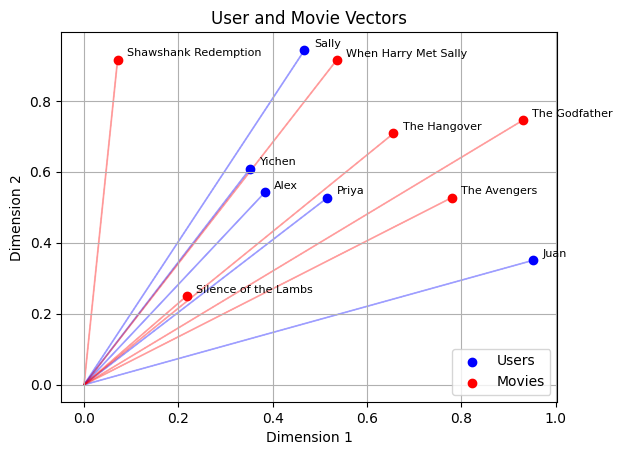

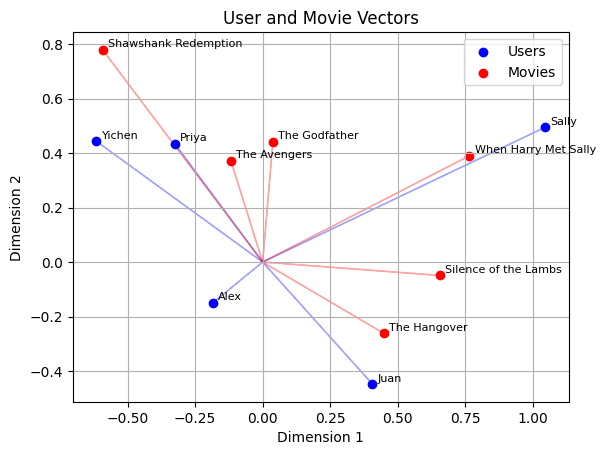

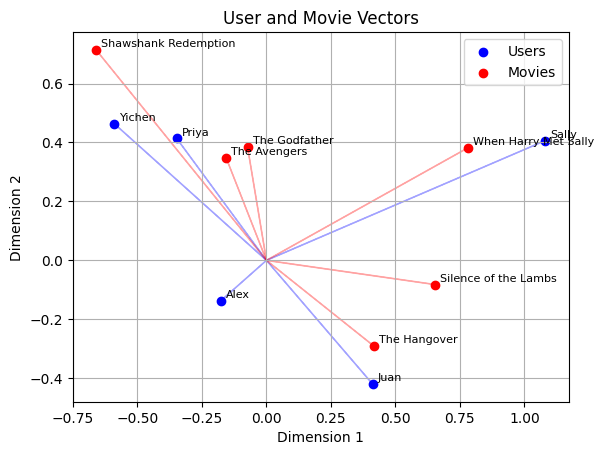

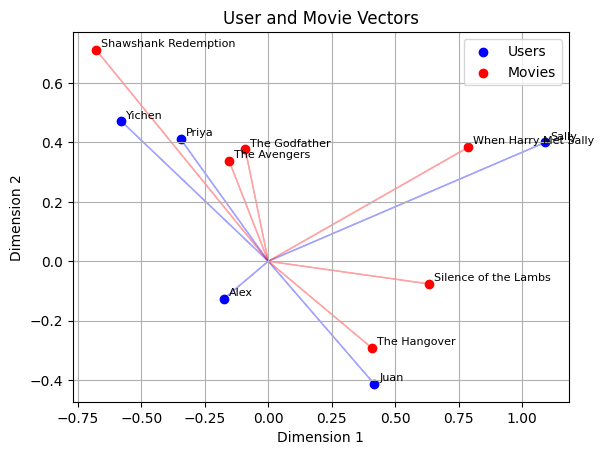

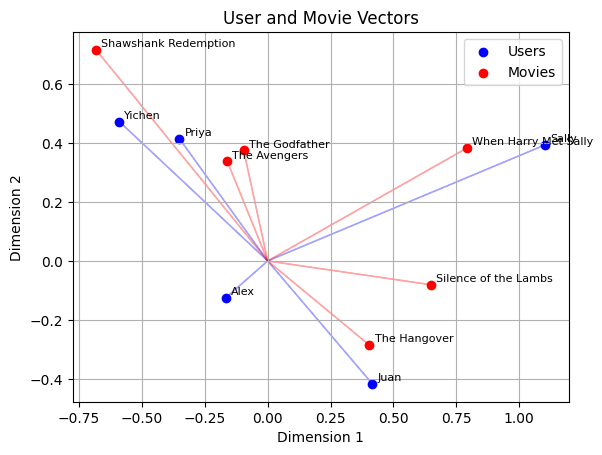

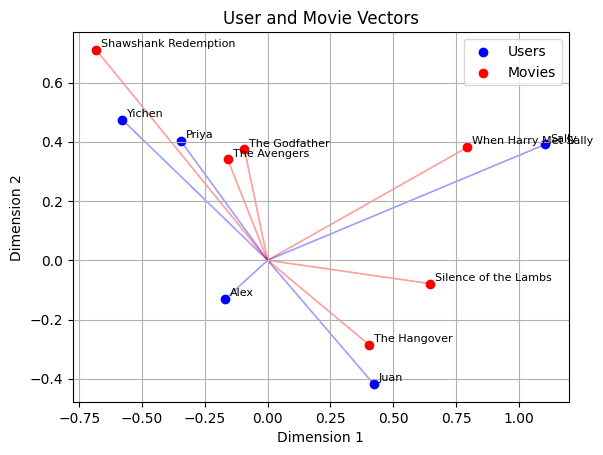

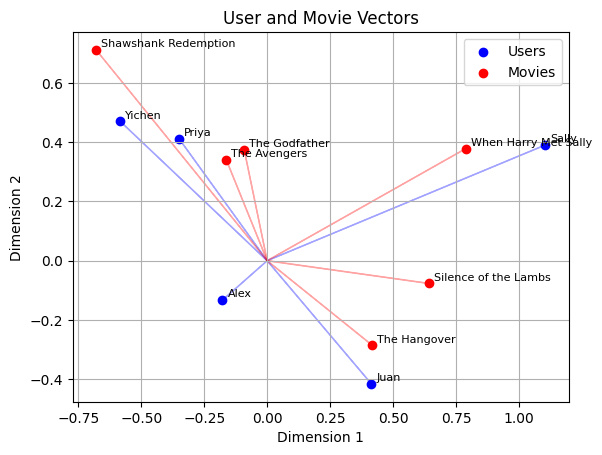

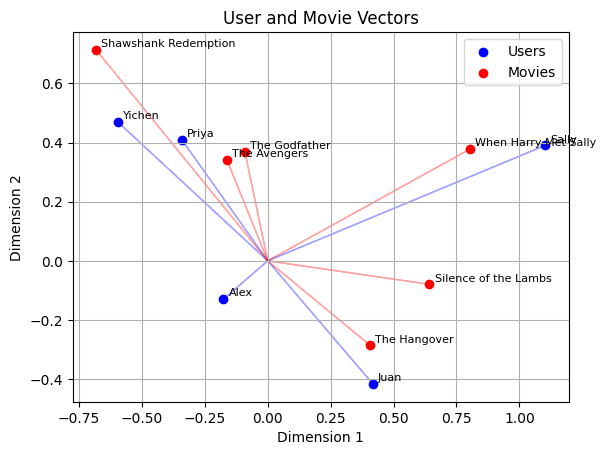

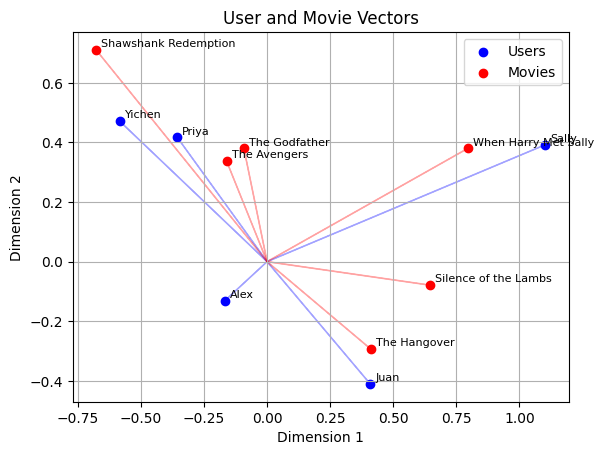

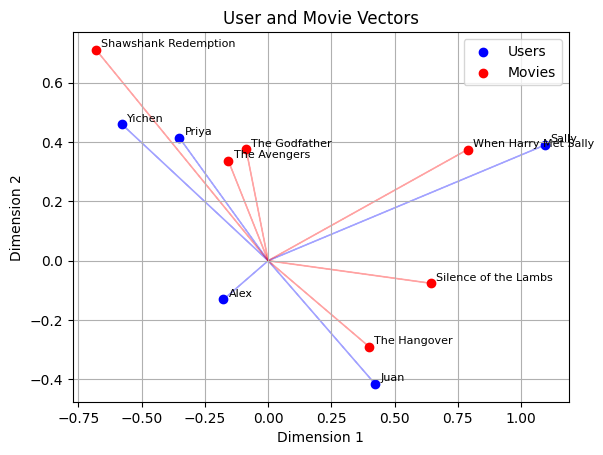

In [10]:
epochs = 1000
alpha = 0.1     # Step size
lamb = 0.1     # Penalizes large vectors
shuffle_after_pass = True
index = list(range(ratings.shape[0]))

for epoch in range(epochs):
    if shuffle_after_pass:
        np.random.shuffle(index)
    for i in index:
        mu = grad_step(V,ratings.iloc[i],alpha,lamb)
    if epoch % 100 == 0:
        plot_vectors(V,ratings)
        # maybe try plotting gradients as well


        

### Assessing your accuracy
Let's predict the ratings for the missing entries using our (randomly initialized) model.

In [11]:
for index, rating in missing_ratings.iterrows():
    user  = rating['user']
    movie = rating['movie']
    prediction = np.dot(V.loc[user],V.loc[movie])+mu
    print(f"Prediction: {user} will rate {movie}: {prediction:.2f}")

Prediction: Sally will rate The Avengers: 3.15
Prediction: Juan will rate The Avengers: 2.99
Prediction: Juan will rate When Harry Met Sally: 3.38
Prediction: Alex will rate Shawshank Redemption: 3.23
Prediction: Sally will rate Shawshank Redemption: 2.73
Prediction: Juan will rate The Hangover: 3.49
Prediction: Sally will rate The Godfather: 3.25
Prediction: Juan will rate The Godfather: 3.01
Prediction: Yichen will rate The Godfather: 3.43
